<a href="https://colab.research.google.com/github/artemkush1/ML_predict_CS-GO_matches/blob/master/prepare_data_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import sys
print(sys.executable)

e:\python\3.6\python.exe


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'seaborn'

In [0]:
df = pd.read_csv('df.csv', comment='#', delimiter=',')

In [10]:
df

,Unnamed: 0,match_url,team1_url,team2_url,5last_matches1_0_0,5last_matches1_0_1,5last_matches1_0_2,5last_matches1_0_3,5last_matches1_0_4,5last_matches1_1_0,5last_matches1_1_1,5last_matches1_1_2,5last_matches1_1_3,5last_matches1_1_4,5last_matches1_2_0,5last_matches1_2_1,5last_matches1_2_2,5last_matches1_2_3,5last_matches1_2_4,5last_matches1_3_0,5last_matches1_3_1,5last_matches1_3_2,5last_matches1_3_3,5last_matches1_3_4,5last_matches1_4_0,5last_matches1_4_1,5last_matches1_4_2,5last_matches1_4_3,5last_matches1_4_4,5last_matches2_0_0,5last_matches2_0_1,5last_matches2_0_2,5last_matches2_0_3,5last_matches2_0_4,5last_matches2_1_0,5last_matches2_1_1,5last_matches2_1_2,5last_matches2_1_3,5last_matches2_1_4,5last_matches2_2_0,...,player3_stat_2,player3_stat_3,player3_stat_4,player3_stat_5,player4_stat_0,player4_stat_1,player4_stat_2,player4_stat_3,player4_stat_4,player4_stat_5,player5_stat_0,player5_stat_1,player5_stat_2,player5_stat_3,player5_stat_4,player5_stat_5,player6_stat_0,player6_stat_1,player6_stat_2,player6_stat_3,player6_stat_4,player6_stat_5,player7_stat_0,player7_stat_1,player7_stat_2,player7_stat_3,player7_stat_4,player7_stat_5,player8_stat_0,player8_stat_1,player8_stat_2,player8_stat_3,player8_stat_4,player8_stat_5,player9_stat_0,player9_stat_1,player9_stat_2,player9_stat_3,player9_stat_4,player9_stat_5
0,0,https://www.hltv.org/matches/2341674/furia-vs-...,https://www.hltv.org/team/8297/furia,https://www.hltv.org/team/9215/mibr,Best of 3,https://www.hltv.org/team/9085/chaos,959,2,1,Best of 3,https://www.hltv.org/team/5973/liquid,994,2,1,Best of 3,https://www.hltv.org/team/9215/mibr,982,2,0,Best of 3,https://www.hltv.org/team/10514/geng,986,1,2,Best of 3,https://www.hltv.org/team/5973/liquid,994,2,0,Best of 3,https://www.hltv.org/team/5973/liquid,994,0,2,Best of 3,https://www.hltv.org/team/9085/chaos,959,2,0,Best of 3,...,0.449,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.16,0.73,0.299,60.0,0.59,0.724,1.16,0.75,0.442,60.0,0.66,0.744,0.93,0.54,0.508,60.0,0.65,0.684,1.13,0.76,0.414,60.0,0.67,0.714,1.08,0.68,0.488,43.0,0.68,0.748
1,1,https://www.hltv.org/matches/2341420/secret-vs...,https://www.hltv.org/team/10488/secret,https://www.hltv.org/team/7969/nemiga,Best of 3,https://www.hltv.org/team/9976/gambit-youngsters,964,0,2,Best of 3,https://www.hltv.org/team/10421/hard-legion,971,2,1,Train,https://www.hltv.org/team/8704/agf,936,25,21,Best of 3,https://www.hltv.org/team/8772/syman,962,1,2,Best of 3,https://www.hltv.org/team/7020/spirit,987,2,1,Inferno,https://www.hltv.org/team/10386/skade,950,22,20,Best of 3,https://www.hltv.org/team/10621/1win,915,1,2,Overpass,...,0.296,69.0,0.65,0.677,0.99,0.63,0.527,38.0,0.66,0.705,1.06,0.67,0.537,68.0,0.64,0.714,1.17,0.76,0.497,68.0,0.64,0.746,1.12,0.70,0.364,68.0,0.63,0.736,1.07,0.64,0.458,68.0,0.68,0.720,1.09,0.68,0.355,68.0,0.60,0.733
2,2,https://www.hltv.org/matches/2341843/alternate...,https://www.hltv.org/team/4501/alternate-attax,https://www.hltv.org/team/8813/illuminar,Best of 3,https://www.hltv.org/team/10150/cr4zy,920,2,0,Best of 3,https://www.hltv.org/team/10509/juggernauts,837,2,0,Best of 3,https://www.hltv.org/team/8637/sprout,965,0,2,Overpass,https://www.hltv.org/team/9928/gamerlegion,0,16,7,Vertigo,https://www.hltv.org/team/7234/endpoint,968,14,16,Best of 3,https://www.hltv.org/team/9797/avez,940,2,1,Best of 3,https://www.hltv.org/team/10105/sgpro,929,2,0,Best of 3,...,0.399,56.0,0.60,0.749,0.97,0.61,0.464,56.0,0.69,0.694,1.04,0.69,0.465,37.0,0.69,0.686,1.02,0.68,0.527,38.0,0.71,0.688,0.97,0.63,0.542,35.0,0.68,0.693,1.01,0.66,0.477,25.0,0.70,0.685,1.02,0.67,0.303,25.0,0.66,0.662
3,3,https://www.hltv.org/matches/2341677/astralis-...,https://www.hltv.org/team/6665/astralis,https://www.hltv.org/team/10567/saw,Train,https://www.hltv.org/team/4411/nip,988,7,16,Best of 3,https://www.hltv.org/team/5995/g2,996,0,2,Best of 3,https://www.hltv.org/team/7533/north,976,2,0,Best of 3,https://www.hltv.org/team/7175/heroic,973,2,0,Best of 5,https://www.hltv.org/team/5995/g2,996,3,0,Be

In [0]:
corr = df.corr()
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(29, 29))
sns.heatmap(corr, mask=None,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmax=1, center=0, vmin=-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

In [22]:
list(df.columns)

['Unnamed: 0',
 'match_url',
 'team1_url',
 'team2_url',
 '5last_matches1_0_0',
 '5last_matches1_0_1',
 '5last_matches1_0_2',
 '5last_matches1_0_3',
 '5last_matches1_0_4',
 '5last_matches1_1_0',
 '5last_matches1_1_1',
 '5last_matches1_1_2',
 '5last_matches1_1_3',
 '5last_matches1_1_4',
 '5last_matches1_2_0',
 '5last_matches1_2_1',
 '5last_matches1_2_2',
 '5last_matches1_2_3',
 '5last_matches1_2_4',
 '5last_matches1_3_0',
 '5last_matches1_3_1',
 '5last_matches1_3_2',
 '5last_matches1_3_3',
 '5last_matches1_3_4',
 '5last_matches1_4_0',
 '5last_matches1_4_1',
 '5last_matches1_4_2',
 '5last_matches1_4_3',
 '5last_matches1_4_4',
 '5last_matches2_0_0',
 '5last_matches2_0_1',
 '5last_matches2_0_2',
 '5last_matches2_0_3',
 '5last_matches2_0_4',
 '5last_matches2_1_0',
 '5last_matches2_1_1',
 '5last_matches2_1_2',
 '5last_matches2_1_3',
 '5last_matches2_1_4',
 '5last_matches2_2_0',
 '5last_matches2_2_1',
 '5last_matches2_2_2',
 '5last_matches2_2_3',
 '5last_matches2_2_4',
 '5last_matches2_3_0',


In [51]:
df.shape

(993, 140)

In [52]:
for i in df.columns:
    try:
        df[i].astype(float)
    except:
        df = df.drop(columns=[i])
df

,Unnamed: 0,5last_matches1_0_2,5last_matches1_0_3,5last_matches1_0_4,5last_matches1_1_2,5last_matches1_1_3,5last_matches1_1_4,5last_matches1_2_2,5last_matches1_2_3,5last_matches1_2_4,5last_matches1_3_2,5last_matches1_3_3,5last_matches1_3_4,5last_matches1_4_2,5last_matches1_4_3,5last_matches1_4_4,5last_matches2_0_2,5last_matches2_0_3,5last_matches2_0_4,5last_matches2_1_2,5last_matches2_1_3,5last_matches2_1_4,5last_matches2_2_2,5last_matches2_2_3,5last_matches2_2_4,5last_matches2_3_2,5last_matches2_3_3,5last_matches2_3_4,5last_matches2_4_2,5last_matches2_4_3,5last_matches2_4_4,history_h2h_1win,history_h2h,history_h2h_2win,rank1,rank2,top30_for_core1,top30_for_core2,average_age1,average_age2,...,player3_stat_2,player3_stat_3,player3_stat_4,player3_stat_5,player4_stat_0,player4_stat_1,player4_stat_2,player4_stat_3,player4_stat_4,player4_stat_5,player5_stat_0,player5_stat_1,player5_stat_2,player5_stat_3,player5_stat_4,player5_stat_5,player6_stat_0,player6_stat_1,player6_stat_2,player6_stat_3,player6_stat_4,player6_stat_5,player7_stat_0,player7_stat_1,player7_stat_2,player7_stat_3,player7_stat_4,player7_stat_5,player8_stat_0,player8_stat_1,player8_stat_2,player8_stat_3,player8_stat_4,player8_stat_5,player9_stat_0,player9_stat_1,player9_stat_2,player9_stat_3,player9_stat_4,player9_stat_5
0,0,959,2,1,994,2,1,982,2,0,986,1,2,994,2,0,994,0,2,959,2,0,992,0,2,992,0,2,966,2,1,12,1,2,992,982,71,198,22.3,27.1,...,0.449,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.16,0.73,0.299,60.0,0.59,0.724,1.16,0.75,0.442,60.0,0.66,0.744,0.93,0.54,0.508,60.0,0.65,0.684,1.13,0.76,0.414,60.0,0.67,0.714,1.08,0.68,0.488,43.0,0.68,0.748
1,1,964,0,2,971,2,1,936,25,21,962,1,2,987,2,1,950,22,20,915,1,2,968,16,10,974,0,2,958,16,10,2,0,0,953,969,0,0,0.0,24.1,...,0.296,69.0,0.65,0.677,0.99,0.63,0.527,38.0,0.66,0.705,1.06,0.67,0.537,68.0,0.64,0.714,1.17,0.76,0.497,68.0,0.64,0.746,1.12,0.70,0.364,68.0,0.63,0.736,1.07,0.64,0.458,68.0,0.68,0.720,1.09,0.68,0.355,68.0,0.60,0.733
2,2,920,2,0,837,2,0,965,0,2,0,16,7,968,14,16,940,2,1,929,2,0,940,1,2,949,1,2,968,0,2,0,0,0,954,912,0,0,24.3,24.7,...,0.399,56.0,0.60,0.749,0.97,0.61,0.464,56.0,0.69,0.694,1.04,0.69,0.465,37.0,0.69,0.686,1.02,0.68,0.527,38.0,0.71,0.688,0.97,0.63,0.542,35.0,0.68,0.693,1.01,0.66,0.477,25.0,0.70,0.685,1.02,0.67,0.303,25.0,0.66,0.662
3,3,988,7,16,996,0,2,976,2,0,973,2,0,996,3,0,970,0,2,975,1,2,823,2,1,0,2,0,869,2,1,0,0,0,998,939,121,0,25.5,26.7,...,0.358,8.0,0.57,0.686,0.98,0.65,0.457,11.0,0.68,0.695,1.16,0.74,0.555,40.0,0.66,0.719,0.98,0.61,0.537,40.0,0.67,0.686,1.10,0.69,0.395,40.0,0.64,0.720,1.05,0.67,0.577,40.0,0.64,0.710,1.04,0.69,0.546,40.0,0.68,0.696
4,4,978,0,2,993,0,2,981,2,1,987,0,2,970,0,2,995,2,0,983,0,2,980,1,2,982,2,1,967,2,0,2,0,0,997,985,226,58,24.5,23.3,...,0.387,70.0,0.66,0.710,0.90,0.56,0.532,70.0,0.68,0.674,1.09,0.68,0.304,36.0,0.59,0.717,1.14,0.72,0.561,36.0,0.63,0.721,1.22,0.77,0.539,36.0,0.65,0.709,1.02,0.63,0.573,36.0,0.66,0.713,1.00,0.61,0.420,36.0,0.61,0.717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,988,972,1,2,950,1,3,887,2,0,858,2,0,887,2,0,945,1,2,928,0,2,970,1,2,835,2,0,915,3,0,2,1,0,956,971,0,14,21.6,23.8,...,0.547,71.0,0.68,0.707,1.07,0.68,0.454,69.0,0.66,0.706,1.12,0.74,0.523,82.0,0.68,0.678,1.12,0.74,0.543,82.0,0.67,0.702,0.99,0.63,0.562,82.0,0.69,0.685,0.97,0.59,0.526,78.0,0.65,0.711,1.05,0.64,0.327,82.0,0.59,0.714
989,989,982,2,0,989,2,1,0,0,2,991,1,2,982,2,1,994,0,2,994,1,2,982,2,1,992,2,1,0,2,0,3,2,13,992,991,71,125,22.3,22.7,...,0.449,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.13,0.76,0.545,42.0,0.66,0.720,1.07,0.68,0.281,43.0,0.65,0.690,1.04,0.65,0.452,42.0,0.68,0.708,1.00,0.65,0.411,42.0,0.70,0.681,0.95,0.58,0.403,42.0,0.65,0.679
990,990,955,2,1,962,2,1,955,5,16,981

In [53]:
arr = []
for x, y in zip(df['score1'], df['score2']):
    if (x > y):
        arr.append(1)
    else:
        arr.append(0)
arr = np.array(arr)
print(len(arr))
df['target'] = arr

993


In [54]:
df

,Unnamed: 0,5last_matches1_0_2,5last_matches1_0_3,5last_matches1_0_4,5last_matches1_1_2,5last_matches1_1_3,5last_matches1_1_4,5last_matches1_2_2,5last_matches1_2_3,5last_matches1_2_4,5last_matches1_3_2,5last_matches1_3_3,5last_matches1_3_4,5last_matches1_4_2,5last_matches1_4_3,5last_matches1_4_4,5last_matches2_0_2,5last_matches2_0_3,5last_matches2_0_4,5last_matches2_1_2,5last_matches2_1_3,5last_matches2_1_4,5last_matches2_2_2,5last_matches2_2_3,5last_matches2_2_4,5last_matches2_3_2,5last_matches2_3_3,5last_matches2_3_4,5last_matches2_4_2,5last_matches2_4_3,5last_matches2_4_4,history_h2h_1win,history_h2h,history_h2h_2win,rank1,rank2,top30_for_core1,top30_for_core2,average_age1,average_age2,...,player3_stat_3,player3_stat_4,player3_stat_5,player4_stat_0,player4_stat_1,player4_stat_2,player4_stat_3,player4_stat_4,player4_stat_5,player5_stat_0,player5_stat_1,player5_stat_2,player5_stat_3,player5_stat_4,player5_stat_5,player6_stat_0,player6_stat_1,player6_stat_2,player6_stat_3,player6_stat_4,player6_stat_5,player7_stat_0,player7_stat_1,player7_stat_2,player7_stat_3,player7_stat_4,player7_stat_5,player8_stat_0,player8_stat_1,player8_stat_2,player8_stat_3,player8_stat_4,player8_stat_5,player9_stat_0,player9_stat_1,player9_stat_2,player9_stat_3,player9_stat_4,player9_stat_5,target
0,0,959,2,1,994,2,1,982,2,0,986,1,2,994,2,0,994,0,2,959,2,0,992,0,2,992,0,2,966,2,1,12,1,2,992,982,71,198,22.3,27.1,...,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.16,0.73,0.299,60.0,0.59,0.724,1.16,0.75,0.442,60.0,0.66,0.744,0.93,0.54,0.508,60.0,0.65,0.684,1.13,0.76,0.414,60.0,0.67,0.714,1.08,0.68,0.488,43.0,0.68,0.748,0
1,1,964,0,2,971,2,1,936,25,21,962,1,2,987,2,1,950,22,20,915,1,2,968,16,10,974,0,2,958,16,10,2,0,0,953,969,0,0,0.0,24.1,...,69.0,0.65,0.677,0.99,0.63,0.527,38.0,0.66,0.705,1.06,0.67,0.537,68.0,0.64,0.714,1.17,0.76,0.497,68.0,0.64,0.746,1.12,0.70,0.364,68.0,0.63,0.736,1.07,0.64,0.458,68.0,0.68,0.720,1.09,0.68,0.355,68.0,0.60,0.733,0
2,2,920,2,0,837,2,0,965,0,2,0,16,7,968,14,16,940,2,1,929,2,0,940,1,2,949,1,2,968,0,2,0,0,0,954,912,0,0,24.3,24.7,...,56.0,0.60,0.749,0.97,0.61,0.464,56.0,0.69,0.694,1.04,0.69,0.465,37.0,0.69,0.686,1.02,0.68,0.527,38.0,0.71,0.688,0.97,0.63,0.542,35.0,0.68,0.693,1.01,0.66,0.477,25.0,0.70,0.685,1.02,0.67,0.303,25.0,0.66,0.662,0
3,3,988,7,16,996,0,2,976,2,0,973,2,0,996,3,0,970,0,2,975,1,2,823,2,1,0,2,0,869,2,1,0,0,0,998,939,121,0,25.5,26.7,...,8.0,0.57,0.686,0.98,0.65,0.457,11.0,0.68,0.695,1.16,0.74,0.555,40.0,0.66,0.719,0.98,0.61,0.537,40.0,0.67,0.686,1.10,0.69,0.395,40.0,0.64,0.720,1.05,0.67,0.577,40.0,0.64,0.710,1.04,0.69,0.546,40.0,0.68,0.696,1
4,4,978,0,2,993,0,2,981,2,1,987,0,2,970,0,2,995,2,0,983,0,2,980,1,2,982,2,1,967,2,0,2,0,0,997,985,226,58,24.5,23.3,...,70.0,0.66,0.710,0.90,0.56,0.532,70.0,0.68,0.674,1.09,0.68,0.304,36.0,0.59,0.717,1.14,0.72,0.561,36.0,0.63,0.721,1.22,0.77,0.539,36.0,0.65,0.709,1.02,0.63,0.573,36.0,0.66,0.713,1.00,0.61,0.420,36.0,0.61,0.717,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,988,972,1,2,950,1,3,887,2,0,858,2,0,887,2,0,945,1,2,928,0,2,970,1,2,835,2,0,915,3,0,2,1,0,956,971,0,14,21.6,23.8,...,71.0,0.68,0.707,1.07,0.68,0.454,69.0,0.66,0.706,1.12,0.74,0.523,82.0,0.68,0.678,1.12,0.74,0.543,82.0,0.67,0.702,0.99,0.63,0.562,82.0,0.69,0.685,0.97,0.59,0.526,78.0,0.65,0.711,1.05,0.64,0.327,82.0,0.59,0.714,0
989,989,982,2,0,989,2,1,0,0,2,991,1,2,982,2,1,994,0,2,994,1,2,982,2,1,992,2,1,0,2,0,3,2,13,992,991,71,125,22.3,22.7,...,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.13,0.76,0.545,42.0,0.66,0.720,1.07,0.68,0.281,43.0,0.65,0.690,1.04,0.65,0.452,42.0,0.68,0.708,1.00,0.65,0.411,42.0,0.70,0.681,0.95,0.58,0.403,42.0,0.65,0.679,0
990,990,955,2,1,962,2,1,955,5,16,981,0,2,998,0,2,964,2,0,958,16,12,993,0

In [0]:
df = df.drop(columns=['Unnamed: 0', 'score1', 'score2'])

In [56]:
df

,5last_matches1_0_2,5last_matches1_0_3,5last_matches1_0_4,5last_matches1_1_2,5last_matches1_1_3,5last_matches1_1_4,5last_matches1_2_2,5last_matches1_2_3,5last_matches1_2_4,5last_matches1_3_2,5last_matches1_3_3,5last_matches1_3_4,5last_matches1_4_2,5last_matches1_4_3,5last_matches1_4_4,5last_matches2_0_2,5last_matches2_0_3,5last_matches2_0_4,5last_matches2_1_2,5last_matches2_1_3,5last_matches2_1_4,5last_matches2_2_2,5last_matches2_2_3,5last_matches2_2_4,5last_matches2_3_2,5last_matches2_3_3,5last_matches2_3_4,5last_matches2_4_2,5last_matches2_4_3,5last_matches2_4_4,history_h2h_1win,history_h2h,history_h2h_2win,rank1,rank2,top30_for_core1,top30_for_core2,average_age1,average_age2,star_cell,...,player3_stat_3,player3_stat_4,player3_stat_5,player4_stat_0,player4_stat_1,player4_stat_2,player4_stat_3,player4_stat_4,player4_stat_5,player5_stat_0,player5_stat_1,player5_stat_2,player5_stat_3,player5_stat_4,player5_stat_5,player6_stat_0,player6_stat_1,player6_stat_2,player6_stat_3,player6_stat_4,player6_stat_5,player7_stat_0,player7_stat_1,player7_stat_2,player7_stat_3,player7_stat_4,player7_stat_5,player8_stat_0,player8_stat_1,player8_stat_2,player8_stat_3,player8_stat_4,player8_stat_5,player9_stat_0,player9_stat_1,player9_stat_2,player9_stat_3,player9_stat_4,player9_stat_5,target
0,959,2,1,994,2,1,982,2,0,986,1,2,994,2,0,994,0,2,959,2,0,992,0,2,992,0,2,966,2,1,12,1,2,992,982,71,198,22.3,27.1,2,...,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.16,0.73,0.299,60.0,0.59,0.724,1.16,0.75,0.442,60.0,0.66,0.744,0.93,0.54,0.508,60.0,0.65,0.684,1.13,0.76,0.414,60.0,0.67,0.714,1.08,0.68,0.488,43.0,0.68,0.748,0
1,964,0,2,971,2,1,936,25,21,962,1,2,987,2,1,950,22,20,915,1,2,968,16,10,974,0,2,958,16,10,2,0,0,953,969,0,0,0.0,24.1,0,...,69.0,0.65,0.677,0.99,0.63,0.527,38.0,0.66,0.705,1.06,0.67,0.537,68.0,0.64,0.714,1.17,0.76,0.497,68.0,0.64,0.746,1.12,0.70,0.364,68.0,0.63,0.736,1.07,0.64,0.458,68.0,0.68,0.720,1.09,0.68,0.355,68.0,0.60,0.733,0
2,920,2,0,837,2,0,965,0,2,0,16,7,968,14,16,940,2,1,929,2,0,940,1,2,949,1,2,968,0,2,0,0,0,954,912,0,0,24.3,24.7,0,...,56.0,0.60,0.749,0.97,0.61,0.464,56.0,0.69,0.694,1.04,0.69,0.465,37.0,0.69,0.686,1.02,0.68,0.527,38.0,0.71,0.688,0.97,0.63,0.542,35.0,0.68,0.693,1.01,0.66,0.477,25.0,0.70,0.685,1.02,0.67,0.303,25.0,0.66,0.662,0
3,988,7,16,996,0,2,976,2,0,973,2,0,996,3,0,970,0,2,975,1,2,823,2,1,0,2,0,869,2,1,0,0,0,998,939,121,0,25.5,26.7,1,...,8.0,0.57,0.686,0.98,0.65,0.457,11.0,0.68,0.695,1.16,0.74,0.555,40.0,0.66,0.719,0.98,0.61,0.537,40.0,0.67,0.686,1.10,0.69,0.395,40.0,0.64,0.720,1.05,0.67,0.577,40.0,0.64,0.710,1.04,0.69,0.546,40.0,0.68,0.696,1
4,978,0,2,993,0,2,981,2,1,987,0,2,970,0,2,995,2,0,983,0,2,980,1,2,982,2,1,967,2,0,2,0,0,997,985,226,58,24.5,23.3,2,...,70.0,0.66,0.710,0.90,0.56,0.532,70.0,0.68,0.674,1.09,0.68,0.304,36.0,0.59,0.717,1.14,0.72,0.561,36.0,0.63,0.721,1.22,0.77,0.539,36.0,0.65,0.709,1.02,0.63,0.573,36.0,0.66,0.713,1.00,0.61,0.420,36.0,0.61,0.717,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,972,1,2,950,1,3,887,2,0,858,2,0,887,2,0,945,1,2,928,0,2,970,1,2,835,2,0,915,3,0,2,1,0,956,971,0,14,21.6,23.8,0,...,71.0,0.68,0.707,1.07,0.68,0.454,69.0,0.66,0.706,1.12,0.74,0.523,82.0,0.68,0.678,1.12,0.74,0.543,82.0,0.67,0.702,0.99,0.63,0.562,82.0,0.69,0.685,0.97,0.59,0.526,78.0,0.65,0.711,1.05,0.64,0.327,82.0,0.59,0.714,0
989,982,2,0,989,2,1,0,0,2,991,1,2,982,2,1,994,0,2,994,1,2,982,2,1,992,2,1,0,2,0,3,2,13,992,991,71,125,22.3,22.7,2,...,48.0,0.56,0.764,1.17,0.70,0.312,48.0,0.56,0.767,1.13,0.76,0.545,42.0,0.66,0.720,1.07,0.68,0.281,43.0,0.65,0.690,1.04,0.65,0.452,42.0,0.68,0.708,1.00,0.65,0.411,42.0,0.70,0.681,0.95,0.58,0.403,42.0,0.65,0.679,0
990,955,2,1,962,2,1,955,5,16,981,0,2,998,0,2,964,2,0,958,16,12,993,0,2,980,2,

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values)

In [57]:
!pip install catboost

     |████████████████████████████████| 64.8MB 61kB/s 


In [113]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

catb = CatBoostClassifier(iterations=1000,
    learning_rate=0.01, depth=None, l2_leaf_reg=None,
    model_size_reg=None, rsm=None, loss_function=None,
    random_seed=None, use_best_model=None, verbose=False,
    custom_loss=None, custom_metric=None,
    eval_metric='Accuracy', bagging_temperature=None,
    boosting_type=None, devices=None,
    bootstrap_type=None, max_depth=None, n_estimators=None,
    num_boost_round=None, num_trees=None,
    random_state=None, max_leaves=None, num_leaves=None,
    leaf_estimation_backtracking=None, boost_from_average=None)


catb.fit(X_train,
    y_train,
    cat_features=None, 
    text_features=None,
    sample_weight=None,
    baseline=None,
    use_best_model=True,
    eval_set=(X_test, y_test),
    verbose=True,
    logging_level=None,
    plot=False,
    column_description=None,
    verbose_eval=None,
    metric_period=None,
    silent=None,
    early_stopping_rounds=None,
    save_snapshot=None,
    snapshot_file=None,
    snapshot_interval=None,
    init_model=None)

0:	learn: 0.6908602	test: 0.5742972	best: 0.5742972 (0)	total: 10.1ms	remaining: 10.1s
1:	learn: 0.7177419	test: 0.6184739	best: 0.6184739 (1)	total: 19.4ms	remaining: 9.66s
2:	learn: 0.7379032	test: 0.6626506	best: 0.6626506 (2)	total: 28.7ms	remaining: 9.54s
3:	learn: 0.7567204	test: 0.6867470	best: 0.6867470 (3)	total: 37.9ms	remaining: 9.43s
4:	learn: 0.7715054	test: 0.6586345	best: 0.6867470 (3)	total: 46.6ms	remaining: 9.28s
5:	learn: 0.7741935	test: 0.6626506	best: 0.6867470 (3)	total: 55.6ms	remaining: 9.21s
6:	learn: 0.7701613	test: 0.6586345	best: 0.6867470 (3)	total: 64.4ms	remaining: 9.14s
7:	learn: 0.7768817	test: 0.6626506	best: 0.6867470 (3)	total: 73.5ms	remaining: 9.11s
8:	learn: 0.7647849	test: 0.6626506	best: 0.6867470 (3)	total: 82.9ms	remaining: 9.13s
9:	learn: 0.7741935	test: 0.6787149	best: 0.6867470 (3)	total: 92.8ms	remaining: 9.19s
10:	learn: 0.7849462	test: 0.7028112	best: 0.7028112 (10)	total: 102ms	remaining: 9.15s
11:	learn: 0.7983871	test: 0.6987952	best:

In [114]:
catb.score(X_train, y_train), catb.score(X_test, y_test)

(0.7997311827956989, 0.7188755020080321)

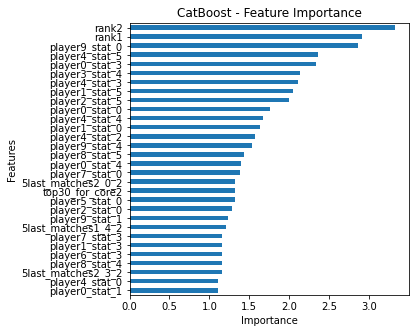

In [112]:
fea_imp = pd.DataFrame({'imp': catb.feature_importances_, 'col': df.columns[:-1]})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(5, 5), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

In [106]:
print(catb.get_best_score())

{'learn': {'Logloss': 0.33078541347229007}, 'validation': {'Logloss': 0.5742686030477901}}
